<a href="https://colab.research.google.com/github/KevinHern/SemProProject1/blob/master/Dermatology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerías

In [1]:
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import Sequential
from tensorflow.keras.utils import get_file
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import os
import shutil
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math


seed=1234
np.random.seed(seed)
tf.random.set_seed(seed)

TensorFlow 2.x selected.


# Dataset

## Extracting

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/KevinHern/SemProProject1/master/dermatology.csv')

## Getting to know the Dataset

In [3]:
df.head()

,2,2.1,0,3,0.1,0.2,0.3,0.4,1,0.5,0.6,0.7,0.8,0.9,0.10,3.1,2.2,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,3.2,0.21,0.22,0.23,1.1,0.24,55,2.3
0,3,3,3,2,1,0,0,0,1,1,1,0,0,1,0,1,2,0,2,2,2,2,2,1,0,0,0,0,0,0,0,1,0,8,1
1,2,1,2,3,1,3,0,3,0,0,0,1,0,0,0,1,2,0,2,0,0,0,0,0,2,0,2,3,2,0,0,2,3,26,3
2,2,2,2,0,0,0,0,0,3,2,0,0,0,3,0,0,2,0,3,2,2,2,2,0,0,3,0,0,0,0,0,3,0,40,1
3,2,3,2,2,2,2,0,2,0,0,0,1,0,0,0,1,2,0,0,0,0,0,0,0,2,2,3,2,3,0,0,2,3,45,3
4,2,3,2,0,0,0,0,0,0,0,0,0,2,1,0,2,2,0,2,0,0,0,1,0,0,0,0,2,0,0,0,1,0,41,2


In [0]:
df.columns = ['erythema', 'scaling', 'definite borders', 'itching', 'koebner phenomenon', 
              'polygonal papules', 'follicular papules', 'oral mucosal involvement', 
              'knee and elbow involvement', 'scalp involvement', 'history', 
               'melanin incontinence', 'eosinophils in the infiltrate', 'PNL infiltrate', 
              'fibrosis of the papillary dermis', 'exocytosis', 'acanthosis', 'hyperkeratosis', 
              'parakeratosis', 'clubbing of the rete ridges', 'elongation of the rete ridges', 
              'thinning of the suprapapillary epidermis', 'spongiform pustule', 'munro microabcess',
              'focal hypergranulosis', 'disappearance of the granular layer', 
              'vacuolisation and damage of basal layer', 'spongiosis', 
              'saw-tooth appearance of retes', 'follicular horn plug', 
              'perifollicular parakeratosis', 'inflammatory monoluclear inflitrate', 'band-like infiltrate','Age', 'Classcode']
df['Classcode'] = df['Classcode'] - 1

In [5]:
df

,erythema,scaling,definite borders,itching,koebner phenomenon,polygonal papules,follicular papules,oral mucosal involvement,knee and elbow involvement,scalp involvement,history,melanin incontinence,eosinophils in the infiltrate,PNL infiltrate,fibrosis of the papillary dermis,exocytosis,acanthosis,hyperkeratosis,parakeratosis,clubbing of the rete ridges,elongation of the rete ridges,thinning of the suprapapillary epidermis,spongiform pustule,munro microabcess,focal hypergranulosis,disappearance of the granular layer,vacuolisation and damage of basal layer,spongiosis,saw-tooth appearance of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear inflitrate,band-like infiltrate,Age,Classcode
0,3,3,3,2,1,0,0,0,1,1,1,0,0,1,0,1,2,0,2,2,2,2,2,1,0,0,0,0,0,0,0,1,0,8,0
1,2,1,2,3,1,3,0,3,0,0,0,1,0,0,0,1,2,0,2,0,0,0,0,0,2,0,2,3,2,0,0,2,3,26,2
2,2,2,2,0,0,0,0,0,3,2,0,0,0,3,0,0,2,0,3,2,2,2,2,0,0,3,0,0,0,0,0,3,0,40,0
3,2,3,2,2,2,2,0,2,0,0,0,1,0,0,0,1,2,0,0,0,0,0,0,0,2,2,3,2,3,0,0,2,3,45,2
4,2,3,2,0,0,0,0,0,0,0,0,0,2,1,0,2,2,0,2,0,0,0,1,0,0,0,0,2,0,0,0,1,0,41,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0,25,3
361,3,2,1,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,1,0,1,0,0,0,2,0,36,3
362,3,2,2,2,3,2,0,2,0,0,0,2,2,0,0,3,3,0,0,0,0,0,0,0,3,0,3,0,3,0,0,2,3,28,2
363,2,1,3,1,2,3,0,2,0,0,0,2,0,0,0,3,2,0,0,0,0,0,0,0,3,0,2,0,1,0,0,2,3,50,2


## Cleaning Dataset

In [6]:
temp = df[df['Age'] != '?']
temp = temp.astype(int)
meanAge = math.floor(temp['Age'].mean())
meanAge

36

In [7]:
df = df.replace('?', meanAge)
df[df['Age'] == '?']

,erythema,scaling,definite borders,itching,koebner phenomenon,polygonal papules,follicular papules,oral mucosal involvement,knee and elbow involvement,scalp involvement,history,melanin incontinence,eosinophils in the infiltrate,PNL infiltrate,fibrosis of the papillary dermis,exocytosis,acanthosis,hyperkeratosis,parakeratosis,clubbing of the rete ridges,elongation of the rete ridges,thinning of the suprapapillary epidermis,spongiform pustule,munro microabcess,focal hypergranulosis,disappearance of the granular layer,vacuolisation and damage of basal layer,spongiosis,saw-tooth appearance of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear inflitrate,band-like infiltrate,Age,Classcode


In [8]:
for i in df.columns:
  df[i] = df[i].astype(int)
df.dtypes

erythema                                    int64
scaling                                     int64
definite borders                            int64
itching                                     int64
koebner phenomenon                          int64
polygonal papules                           int64
follicular papules                          int64
oral mucosal involvement                    int64
knee and elbow involvement                  int64
scalp involvement                           int64
history                                     int64
melanin incontinence                        int64
eosinophils in the infiltrate               int64
PNL infiltrate                              int64
fibrosis of the papillary dermis            int64
exocytosis                                  int64
acanthosis                                  int64
hyperkeratosis                              int64
parakeratosis                               int64
clubbing of the rete ridges                 int64


## Correlation

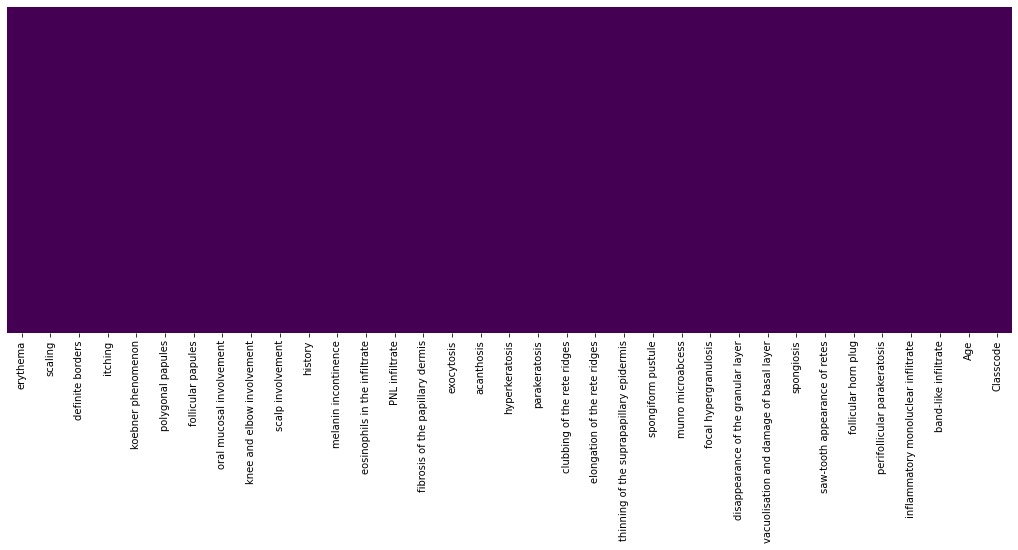

In [9]:
plt.figure(figsize=(18,6))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis', xticklabels=True)

In [0]:
corr = df.corr()

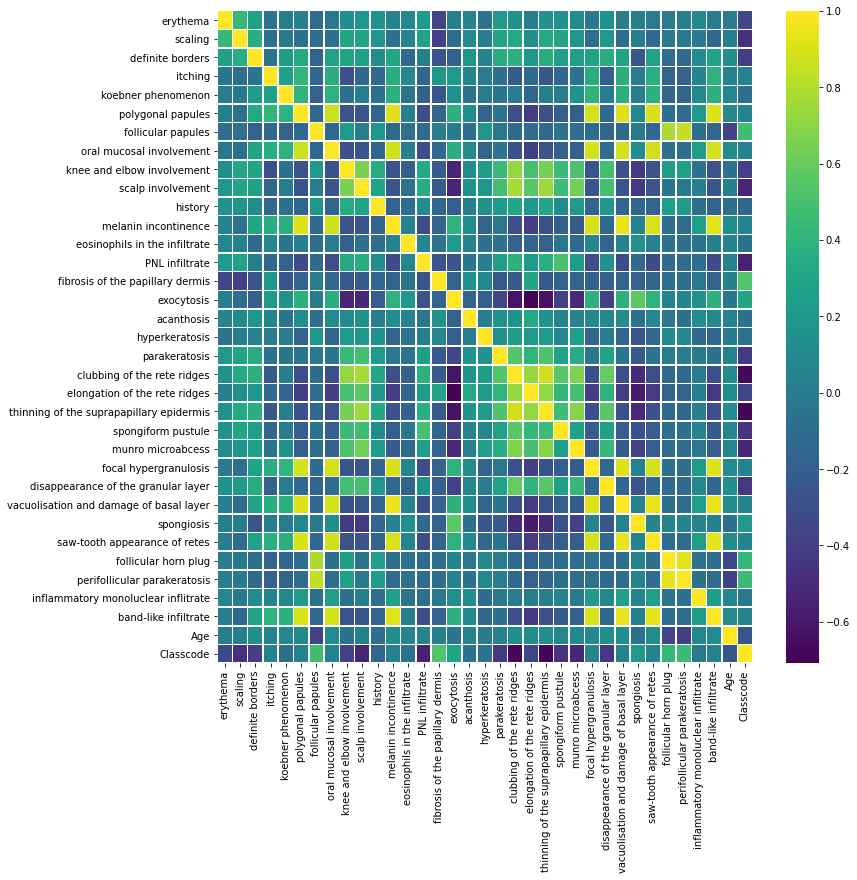

In [11]:
plt.figure(figsize=(12,12))
sns.heatmap(corr, linewidths=.5, cmap='viridis')

# Models

Metodología:
Queremos ver qué modelo tiene mejor Accuracy utilizando diversos conjuntos de features
Se realizan 4 modelos:

1.   Un modelo que utiliza todos los features del dataset.
2.   Un modelo que utiliza únicamente los features clínicos
3.   Un modelo que utiliza únicamente los datos histopatológicos
4.   Un modelo que utiliza los features más importantes extraídos del heatmap

El approach que se empleará para determinar qué arquitectura es la mejor continene las siguientes condiciones:

*   Los 4 modelos se someterán a los mismos datasets
*   Los 4 modelos tendrán las mismas arquitecturas para ser comparables. Las capas ocultas tendrán neuronas en potencias de 2
*   Se realizarán 4 pruebas, donde cada prueba se utilizará una arquitectura distinta.







## Macro Variables
Definición de variables macros que sirven para los epochs, validation split y batch size

In [0]:
epochs = 5
split = 0.2
batch = 32

## Model Functions

Funciones que serán usados en la definición e implementación de los modelos.
El propósito es disminuir la cantidad de código que se tiene que escribir

#### Models Definitions

In [0]:
# 2 Hidden Layer Model Definition
def model2h(inputShape):
  model = Sequential([
      Dense(1024, activation='relu', input_shape=(inputShape,)),
      Dense(512, activation='relu'),
      Dense(6, activation='softmax')
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [0]:
# 3 Hidden Layer Model Definition
def model3h(inputShape):
  model = Sequential([
      Dense(1024, activation='relu', input_shape=(inputShape,)),
      Dense(512, activation='relu'),
      Dense(256, activation='relu'),
      Dense(6, activation='softmax')
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [0]:
# 4 Hidden Layer Model Definition
def model4h(inputShape):
  model = Sequential([
      Dense(1024, activation='relu', input_shape=(inputShape,)),
      Dense(512, activation='relu'),
      Dense(256, activation='relu'),
      Dense(128, activation='relu'),
      Dense(6, activation='softmax')
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [0]:
# 5 Hidden Layer Model Definition
def model5h(inputShape):
  model = Sequential([
      Dense(1024, activation='relu', input_shape=(inputShape,)),
      Dense(512, activation='relu'),
      Dense(256, activation='relu'),
      Dense(128, activation='relu'),
      Dense(64, activation='relu'),
      Dense(6, activation='softmax')
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

#### Fit Function

In [0]:
def train_model(model, data, labels):
  print("Training")
  return model.fit(data,
                      labels,
                      epochs=epochs,
                      #validation_data=validation_split,
                      batch_size=batch,
                      validation_split=split
                    )

#### Evaluation Function

In [0]:
def evaluate_model(model, data, labels):
  print("\nEvaluation")
  return model.evaluate(data, labels)

#### Prediction Function

In [0]:
def predictions_model(model, data):
  return model.predict(data)

## Splitting Dataset Functions
Funciones que serán usadas para separar el dataset en los distintos sub-datasets para realizar las distintas pruebas .
El propósito es disminuir la cantidad de código que se tiene que escribir

Luego, para cada sub-dataset, lo particionamos en:

*   75% training
*   25% test

Durante el entrenamiento del modelo, el dataset de training se parte en:



*   80% training
*   20% validation



### All Features
Únicamente se separan los labels y los datos

In [0]:
def all_features(dataset):
  
  train_split = dataset.sample(frac = 0.75)
  test_split = dataset.drop(train_split.index)

  train_labels = train_split['Classcode']
  train_data = train_split
  train_data = train_data.drop(columns=['Classcode'])

  test_labels = test_split['Classcode']
  test_data = test_split
  test_data = test_data.drop(columns=['Classcode'])

  return train_data, train_labels, test_data, test_labels 


### Clinical Features

Se obtienen únicamente los features que son clínicos

In [0]:
def clinical_features(dataset):
  subset = dataset[['erythema', 'scaling', 'definite borders', 'itching', 'koebner phenomenon', 
              'polygonal papules', 'follicular papules', 'oral mucosal involvement', 
              'knee and elbow involvement', 'scalp involvement', 'history', 'Age', 'Classcode']]

  train_split = subset.sample(frac = 0.75,random_state=42)
  test_split = subset.drop(train_split.index)
  
  train_labels = train_split['Classcode']
  train_data = train_split
  train_data = train_data.drop(columns=['Classcode'])

  test_labels = test_split['Classcode']
  test_data = test_split
  test_data = test_data.drop(columns=['Classcode'])

  return train_data, train_labels, test_data, test_labels 

### Histopathological Features

Se obtienen únicamente los features que son histopatológicos

In [0]:
def histopathological_features(dataset):
  subset = dataset[['melanin incontinence', 'eosinophils in the infiltrate', 'PNL infiltrate', 
              'fibrosis of the papillary dermis', 'exocytosis', 'acanthosis', 'hyperkeratosis', 
              'parakeratosis', 'clubbing of the rete ridges', 'elongation of the rete ridges', 
              'thinning of the suprapapillary epidermis', 'spongiform pustule', 'munro microabcess',
              'focal hypergranulosis', 'disappearance of the granular layer', 
              'vacuolisation and damage of basal layer', 'spongiosis', 
              'saw-tooth appearance of retes', 'follicular horn plug', 
              'perifollicular parakeratosis', 'inflammatory monoluclear inflitrate', 'band-like infiltrate','Age', 'Classcode']]

  train_split = subset.sample(frac = 0.75)#,random_state=42)
  test_split = subset.drop(train_split.index)
  
  train_labels = train_split['Classcode']
  train_data = train_split
  train_data = train_data.drop(columns=['Classcode'])

  test_labels = test_split['Classcode']
  test_data = test_split
  test_data = test_data.drop(columns=['Classcode'])

  return train_data, train_labels, test_data, test_labels 

### Important Features from the Correlation Heatmap

Se obtienen los features más importantes según el heatmap, aquellos que tiene una corealacion menor a 90%

In [0]:
def heatmap_features(dataset):
  subset = dataset[['Age','inflammatory monoluclear inflitrate','spongiosis',
                    'disappearance of the granular layer','munro microabcess','spongiform pustule',
                    'elongation of the rete ridges','parakeratosis','hyperkeratosis','acanthosis','exocytosis',
                    'fibrosis of the papillary dermis','PNL infiltrate','eosinophils in the infiltrate',
                    'history','scalp involvement','knee and elbow involvement','follicular papules',
                    'koebner phenomenon','itching','definite borders','scaling','erythema', 'Classcode']]

  train_split = subset.sample(frac = 0.75)
  test_split = subset.drop(train_split.index)
  
  train_labels = train_split['Classcode']
  train_data = train_split
  train_data = train_data.drop(columns=['Classcode'])

  test_labels = test_split['Classcode']
  test_data = test_split
  test_data = test_data.drop(columns=['Classcode'])

  return train_data, train_labels, test_data, test_labels 

## Model 1: 2 hidden layers

In [0]:
# A matrix where all model 1's info is stored
# Rows represent the test number
# Columns represent: 
#   1. Model
#   2. Evaluation
#   3. Predictions
summary_model1 = [[0 for x in range(3)] for y in range(4)]


### Test 1: All Features

In [25]:
train_data, train_labels, test_data, test_labels = all_features(df)

# Model
summary_model1[0][0] = model2h(train_data.shape[1])
model = summary_model1[0][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model1[0][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model1[0][2] =  predictions_model(model, test_data)

Training
Train on 219 samples, validate on 55 samples
Epoch 1/5
219/219 [==============================] - 1s 3ms/sample - loss: 2.9789 - accuracy: 0.2694 - val_loss: 1.8920 - val_accuracy: 0.3091
Epoch 2/5
219/219 [==============================] - 0s 324us/sample - loss: 1.2649 - accuracy: 0.5205 - val_loss: 0.6671 - val_accuracy: 0.7273
Epoch 3/5
219/219 [==============================] - 0s 289us/sample - loss: 0.5983 - accuracy: 0.7671 - val_loss: 0.3839 - val_accuracy: 0.9091
Epoch 4/5
219/219 [==============================] - 0s 323us/sample - loss: 0.3318 - accuracy: 0.9087 - val_loss: 0.3794 - val_accuracy: 0.9273
Epoch 5/5
219/219 [==============================] - 0s 311us/sample - loss: 0.2190 - accuracy: 0.9498 - val_loss: 0.1922 - val_accuracy: 0.9636

Evaluation
91/91 [==============================] - 0s 108us/sample - loss: 0.2196 - accuracy: 0.9011


### Test 2: Clinical Features

In [26]:
train_data, train_labels, test_data, test_labels = clinical_features(df)

# Model
summary_model1[1][0] = model2h(train_data.shape[1])
model = summary_model1[1][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model1[1][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model1[1][2] =  predictions_model(model, test_data)

Training
Train on 219 samples, validate on 55 samples
Epoch 1/5
219/219 [==============================] - 0s 2ms/sample - loss: 3.6879 - accuracy: 0.2192 - val_loss: 2.1808 - val_accuracy: 0.3818
Epoch 2/5
219/219 [==============================] - 0s 288us/sample - loss: 2.5515 - accuracy: 0.3607 - val_loss: 1.0963 - val_accuracy: 0.6545
Epoch 3/5
219/219 [==============================] - 0s 303us/sample - loss: 1.5308 - accuracy: 0.4475 - val_loss: 0.9504 - val_accuracy: 0.6727
Epoch 4/5
219/219 [==============================] - 0s 287us/sample - loss: 1.1523 - accuracy: 0.5434 - val_loss: 0.7272 - val_accuracy: 0.7636
Epoch 5/5
219/219 [==============================] - 0s 322us/sample - loss: 0.9763 - accuracy: 0.6027 - val_loss: 0.7648 - val_accuracy: 0.7091

Evaluation
91/91 [==============================] - 0s 128us/sample - loss: 0.8216 - accuracy: 0.7253


### Test 3: Histopathological Features

In [27]:
train_data, train_labels, test_data, test_labels = histopathological_features(df)

# Model
summary_model1[2][0] = model2h(train_data.shape[1])
model = summary_model1[2][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model1[2][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model1[2][2] =  predictions_model(model, test_data)

Training
Train on 219 samples, validate on 55 samples
Epoch 1/5
219/219 [==============================] - 0s 2ms/sample - loss: 2.6003 - accuracy: 0.2648 - val_loss: 2.1835 - val_accuracy: 0.4364
Epoch 2/5
219/219 [==============================] - 0s 318us/sample - loss: 1.5078 - accuracy: 0.5068 - val_loss: 1.2762 - val_accuracy: 0.4909
Epoch 3/5
219/219 [==============================] - 0s 291us/sample - loss: 0.8076 - accuracy: 0.6986 - val_loss: 0.8293 - val_accuracy: 0.7818
Epoch 4/5
219/219 [==============================] - 0s 298us/sample - loss: 0.5304 - accuracy: 0.8447 - val_loss: 0.4800 - val_accuracy: 0.8364
Epoch 5/5
219/219 [==============================] - 0s 295us/sample - loss: 0.4364 - accuracy: 0.8402 - val_loss: 0.3491 - val_accuracy: 0.8727

Evaluation
91/91 [==============================] - 0s 137us/sample - loss: 0.3466 - accuracy: 0.8352


### Test 4: Important Features from the Correlation Heatmap

In [28]:
train_data, train_labels, test_data, test_labels = heatmap_features(df)

# Model
summary_model1[3][0] = model2h(train_data.shape[1])
model = summary_model1[3][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model1[3][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model1[3][2] =  predictions_model(model, test_data)

Training
Train on 219 samples, validate on 55 samples
Epoch 1/5
219/219 [==============================] - 0s 2ms/sample - loss: 2.8487 - accuracy: 0.2785 - val_loss: 1.5869 - val_accuracy: 0.3273
Epoch 2/5
219/219 [==============================] - 0s 310us/sample - loss: 1.3786 - accuracy: 0.4658 - val_loss: 1.4242 - val_accuracy: 0.7455
Epoch 3/5
219/219 [==============================] - 0s 308us/sample - loss: 1.1179 - accuracy: 0.7123 - val_loss: 0.7583 - val_accuracy: 0.6545
Epoch 4/5
219/219 [==============================] - 0s 325us/sample - loss: 0.6998 - accuracy: 0.7443 - val_loss: 0.6064 - val_accuracy: 0.7636
Epoch 5/5
219/219 [==============================] - 0s 302us/sample - loss: 0.4917 - accuracy: 0.8447 - val_loss: 0.3839 - val_accuracy: 0.8909

Evaluation
91/91 [==============================] - 0s 127us/sample - loss: 0.3163 - accuracy: 0.9231


## Model 2: 3 hidden layers

In [0]:
# A matrix where all model 2's info is stored
# Rows represent the test number
# Columns represent: 
#   1. Model
#   2. Evaluation
#   3. Predictions
summary_model2 = [[0 for x in range(3)] for y in range(4)]


### Test 1: All Features

In [30]:
train_data, train_labels, test_data, test_labels = all_features(df)

# Model
summary_model2[0][0] = model3h(train_data.shape[1])
model = summary_model2[0][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model2[0][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model2[0][2] =  predictions_model(model, test_data)

Training
Train on 219 samples, validate on 55 samples
Epoch 1/5
219/219 [==============================] - 0s 2ms/sample - loss: 1.9814 - accuracy: 0.3516 - val_loss: 0.9447 - val_accuracy: 0.8000
Epoch 2/5
219/219 [==============================] - 0s 369us/sample - loss: 0.9825 - accuracy: 0.6986 - val_loss: 0.5226 - val_accuracy: 0.9273
Epoch 3/5
219/219 [==============================] - 0s 358us/sample - loss: 0.5574 - accuracy: 0.8630 - val_loss: 0.2821 - val_accuracy: 0.9455
Epoch 4/5
219/219 [==============================] - 0s 383us/sample - loss: 0.3511 - accuracy: 0.9041 - val_loss: 0.2361 - val_accuracy: 0.9455
Epoch 5/5
219/219 [==============================] - 0s 332us/sample - loss: 0.2494 - accuracy: 0.9406 - val_loss: 0.1554 - val_accuracy: 0.9636

Evaluation
91/91 [==============================] - 0s 129us/sample - loss: 0.2242 - accuracy: 0.9011


### Test 2: Clinical Features

In [31]:
train_data, train_labels, test_data, test_labels = clinical_features(df)

# Model
summary_model2[1][0] = model3h(train_data.shape[1])
model = summary_model2[1][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model2[1][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model2[1][2] =  predictions_model(model, test_data)

Training
Train on 219 samples, validate on 55 samples
Epoch 1/5
219/219 [==============================] - 0s 2ms/sample - loss: 2.3375 - accuracy: 0.2648 - val_loss: 1.6562 - val_accuracy: 0.4909
Epoch 2/5
219/219 [==============================] - 0s 406us/sample - loss: 1.5499 - accuracy: 0.4247 - val_loss: 1.3692 - val_accuracy: 0.6000
Epoch 3/5
219/219 [==============================] - 0s 337us/sample - loss: 1.3627 - accuracy: 0.4521 - val_loss: 1.0351 - val_accuracy: 0.7455
Epoch 4/5
219/219 [==============================] - 0s 356us/sample - loss: 1.2374 - accuracy: 0.5342 - val_loss: 1.0019 - val_accuracy: 0.6000
Epoch 5/5
219/219 [==============================] - 0s 345us/sample - loss: 1.1028 - accuracy: 0.5251 - val_loss: 0.6469 - val_accuracy: 0.7455

Evaluation
91/91 [==============================] - 0s 142us/sample - loss: 0.7821 - accuracy: 0.6703


### Test 3: Histopathological Features

In [32]:
train_data, train_labels, test_data, test_labels = histopathological_features(df)

# Model
summary_model2[2][0] = model3h(train_data.shape[1])
model = summary_model2[2][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model2[2][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model2[2][2] =  predictions_model(model, test_data)

Training
Train on 219 samples, validate on 55 samples
Epoch 1/5
219/219 [==============================] - 0s 2ms/sample - loss: 2.4744 - accuracy: 0.3014 - val_loss: 2.5662 - val_accuracy: 0.2182
Epoch 2/5
219/219 [==============================] - 0s 348us/sample - loss: 1.5623 - accuracy: 0.4658 - val_loss: 1.2156 - val_accuracy: 0.6000
Epoch 3/5
219/219 [==============================] - 0s 335us/sample - loss: 0.9281 - accuracy: 0.6621 - val_loss: 0.6834 - val_accuracy: 0.7636
Epoch 4/5
219/219 [==============================] - 0s 342us/sample - loss: 0.5895 - accuracy: 0.8037 - val_loss: 0.5317 - val_accuracy: 0.8545
Epoch 5/5
219/219 [==============================] - 0s 308us/sample - loss: 0.4101 - accuracy: 0.8721 - val_loss: 0.5214 - val_accuracy: 0.7636

Evaluation
91/91 [==============================] - 0s 127us/sample - loss: 0.4440 - accuracy: 0.8352


### Test 4: Important Features from the Correlation Heatmap

In [33]:
train_data, train_labels, test_data, test_labels = heatmap_features(df)

# Model
summary_model2[3][0] = model3h(train_data.shape[1])
model = summary_model2[3][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model2[3][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model2[3][2] =  predictions_model(model, test_data)

Training
Train on 219 samples, validate on 55 samples
Epoch 1/5
219/219 [==============================] - 0s 2ms/sample - loss: 2.4925 - accuracy: 0.2329 - val_loss: 1.8058 - val_accuracy: 0.3091
Epoch 2/5
219/219 [==============================] - 0s 367us/sample - loss: 1.5568 - accuracy: 0.3562 - val_loss: 1.2163 - val_accuracy: 0.7091
Epoch 3/5
219/219 [==============================] - 0s 330us/sample - loss: 1.1323 - accuracy: 0.5753 - val_loss: 0.9839 - val_accuracy: 0.7818
Epoch 4/5
219/219 [==============================] - 0s 403us/sample - loss: 0.8908 - accuracy: 0.7306 - val_loss: 0.7103 - val_accuracy: 0.8000
Epoch 5/5
219/219 [==============================] - 0s 345us/sample - loss: 0.5762 - accuracy: 0.8402 - val_loss: 0.6556 - val_accuracy: 0.6000

Evaluation
91/91 [==============================] - 0s 124us/sample - loss: 0.6950 - accuracy: 0.6374


## Model 3: 4 hidden layers

In [0]:
# A matrix where all model 3's info is stored
# Rows represent the test number
# Columns represent: 
#   1. Model
#   2. Evaluation
#   3. Predictions
summary_model3 = [[0 for x in range(3)] for y in range(4)]


### Test 1: All Features

In [35]:
train_data, train_labels, test_data, test_labels = all_features(df)

# Model
summary_model3[0][0] = model4h(train_data.shape[1])
model = summary_model3[0][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model3[0][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model3[0][2] =  predictions_model(model, test_data)

Training
Train on 219 samples, validate on 55 samples
Epoch 1/5
219/219 [==============================] - 0s 2ms/sample - loss: 1.8045 - accuracy: 0.3699 - val_loss: 1.7084 - val_accuracy: 0.2727
Epoch 2/5
219/219 [==============================] - 0s 353us/sample - loss: 1.0540 - accuracy: 0.6301 - val_loss: 1.1294 - val_accuracy: 0.4364
Epoch 3/5
219/219 [==============================] - 0s 377us/sample - loss: 0.6433 - accuracy: 0.7945 - val_loss: 0.7004 - val_accuracy: 0.8000
Epoch 4/5
219/219 [==============================] - 0s 387us/sample - loss: 0.4122 - accuracy: 0.8767 - val_loss: 0.5114 - val_accuracy: 0.8182
Epoch 5/5
219/219 [==============================] - 0s 386us/sample - loss: 0.2689 - accuracy: 0.8995 - val_loss: 0.4251 - val_accuracy: 0.8364

Evaluation
91/91 [==============================] - 0s 144us/sample - loss: 0.2841 - accuracy: 0.8791


### Test 2: Clinical Features

In [36]:
train_data, train_labels, test_data, test_labels = clinical_features(df)

# Model
summary_model3[1][0] = model4h(train_data.shape[1])
model = summary_model3[1][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model3[1][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model3[1][2] =  predictions_model(model, test_data)

Training
Train on 219 samples, validate on 55 samples
Epoch 1/5
219/219 [==============================] - 0s 2ms/sample - loss: 1.9336 - accuracy: 0.2009 - val_loss: 1.4731 - val_accuracy: 0.6000
Epoch 2/5
219/219 [==============================] - 0s 416us/sample - loss: 1.5295 - accuracy: 0.3653 - val_loss: 1.6427 - val_accuracy: 0.2727
Epoch 3/5
219/219 [==============================] - 0s 405us/sample - loss: 1.6282 - accuracy: 0.3196 - val_loss: 1.3209 - val_accuracy: 0.5091
Epoch 4/5
219/219 [==============================] - 0s 390us/sample - loss: 1.3642 - accuracy: 0.4292 - val_loss: 1.0859 - val_accuracy: 0.6727
Epoch 5/5
219/219 [==============================] - 0s 356us/sample - loss: 1.2370 - accuracy: 0.5297 - val_loss: 0.7761 - val_accuracy: 0.6727

Evaluation
91/91 [==============================] - 0s 126us/sample - loss: 0.9679 - accuracy: 0.6484


### Test 3: Histopathological Features

In [37]:
train_data, train_labels, test_data, test_labels = histopathological_features(df)

# Model
summary_model3[2][0] = model4h(train_data.shape[1])
model = summary_model3[2][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model3[2][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model3[2][2] =  predictions_model(model, test_data)

Training
Train on 219 samples, validate on 55 samples
Epoch 1/5
219/219 [==============================] - 1s 3ms/sample - loss: 1.7818 - accuracy: 0.4110 - val_loss: 1.2521 - val_accuracy: 0.5636
Epoch 2/5
219/219 [==============================] - 0s 392us/sample - loss: 1.1685 - accuracy: 0.5936 - val_loss: 0.8605 - val_accuracy: 0.7273
Epoch 3/5
219/219 [==============================] - 0s 381us/sample - loss: 0.8280 - accuracy: 0.6621 - val_loss: 0.7703 - val_accuracy: 0.6364
Epoch 4/5
219/219 [==============================] - 0s 364us/sample - loss: 0.6446 - accuracy: 0.7717 - val_loss: 0.4346 - val_accuracy: 0.8364
Epoch 5/5
219/219 [==============================] - 0s 391us/sample - loss: 0.4266 - accuracy: 0.8128 - val_loss: 0.3561 - val_accuracy: 0.8364

Evaluation
91/91 [==============================] - 0s 159us/sample - loss: 0.3386 - accuracy: 0.8791


### Test 4: Important Features from the Correlation Heatmap

In [38]:
train_data, train_labels, test_data, test_labels = heatmap_features(df)

# Model
summary_model3[3][0] = model4h(train_data.shape[1])
model = summary_model3[3][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model3[3][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model3[3][2] =  predictions_model(model, test_data)

Training
Train on 219 samples, validate on 55 samples
Epoch 1/5
219/219 [==============================] - 0s 2ms/sample - loss: 2.0401 - accuracy: 0.2192 - val_loss: 1.4191 - val_accuracy: 0.3636
Epoch 2/5
219/219 [==============================] - 0s 359us/sample - loss: 1.5421 - accuracy: 0.4064 - val_loss: 1.4319 - val_accuracy: 0.5273
Epoch 3/5
219/219 [==============================] - 0s 413us/sample - loss: 1.2319 - accuracy: 0.6027 - val_loss: 1.0062 - val_accuracy: 0.6000
Epoch 4/5
219/219 [==============================] - 0s 366us/sample - loss: 0.9426 - accuracy: 0.6438 - val_loss: 0.8156 - val_accuracy: 0.6727
Epoch 5/5
219/219 [==============================] - 0s 406us/sample - loss: 0.7811 - accuracy: 0.7032 - val_loss: 0.6794 - val_accuracy: 0.6909

Evaluation
91/91 [==============================] - 0s 153us/sample - loss: 0.6518 - accuracy: 0.6484


## Model 4: 5 hidden layers

In [0]:
# A matrix where all model 4's info is stored
# Rows represent the test number
# Columns represent: 
#   1. Model
#   2. Evaluation
#   3. Predictions
summary_model4 = [[0 for x in range(3)] for y in range(4)]


### Test 1: All Features

In [40]:
train_data, train_labels, test_data, test_labels = all_features(df)

# Model
summary_model4[0][0] = model5h(train_data.shape[1])
model = summary_model4[0][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model4[0][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model4[0][2] =  predictions_model(model, test_data)

Training
Train on 219 samples, validate on 55 samples
Epoch 1/5
219/219 [==============================] - 0s 2ms/sample - loss: 1.7607 - accuracy: 0.2648 - val_loss: 1.4532 - val_accuracy: 0.3818
Epoch 2/5
219/219 [==============================] - 0s 361us/sample - loss: 1.2741 - accuracy: 0.4795 - val_loss: 1.0486 - val_accuracy: 0.5636
Epoch 3/5
219/219 [==============================] - 0s 385us/sample - loss: 0.9035 - accuracy: 0.6393 - val_loss: 0.7312 - val_accuracy: 0.6909
Epoch 4/5
219/219 [==============================] - 0s 330us/sample - loss: 0.6059 - accuracy: 0.7671 - val_loss: 0.5357 - val_accuracy: 0.8000
Epoch 5/5
219/219 [==============================] - 0s 356us/sample - loss: 0.4794 - accuracy: 0.8584 - val_loss: 0.4227 - val_accuracy: 0.8364

Evaluation
91/91 [==============================] - 0s 171us/sample - loss: 0.4551 - accuracy: 0.7912


### Test 2: Clinical Features

In [41]:
train_data, train_labels, test_data, test_labels = clinical_features(df)

# Model
summary_model4[1][0] = model5h(train_data.shape[1])
model = summary_model4[1][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model4[1][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model4[1][2] =  predictions_model(model, test_data)

Training
Train on 219 samples, validate on 55 samples
Epoch 1/5
219/219 [==============================] - 0s 2ms/sample - loss: 1.7552 - accuracy: 0.2648 - val_loss: 1.6262 - val_accuracy: 0.2727
Epoch 2/5
219/219 [==============================] - 0s 371us/sample - loss: 1.6167 - accuracy: 0.3562 - val_loss: 1.6378 - val_accuracy: 0.1091
Epoch 3/5
219/219 [==============================] - 0s 403us/sample - loss: 1.6161 - accuracy: 0.2740 - val_loss: 1.4448 - val_accuracy: 0.4182
Epoch 4/5
219/219 [==============================] - 0s 359us/sample - loss: 1.5285 - accuracy: 0.4064 - val_loss: 1.2919 - val_accuracy: 0.4727
Epoch 5/5
219/219 [==============================] - 0s 350us/sample - loss: 1.3596 - accuracy: 0.4840 - val_loss: 1.1475 - val_accuracy: 0.6727

Evaluation
91/91 [==============================] - 0s 123us/sample - loss: 1.1428 - accuracy: 0.7033


### Test 3: Histopathological Features

In [42]:
train_data, train_labels, test_data, test_labels = histopathological_features(df)

# Model
summary_model4[2][0] = model5h(train_data.shape[1])
model = summary_model4[2][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model4[2][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model4[2][2] =  predictions_model(model, test_data)

Training
Train on 219 samples, validate on 55 samples
Epoch 1/5
219/219 [==============================] - 0s 2ms/sample - loss: 1.6901 - accuracy: 0.2877 - val_loss: 1.5471 - val_accuracy: 0.3818
Epoch 2/5
219/219 [==============================] - 0s 360us/sample - loss: 1.3576 - accuracy: 0.5297 - val_loss: 1.2209 - val_accuracy: 0.4727
Epoch 3/5
219/219 [==============================] - 0s 349us/sample - loss: 1.0572 - accuracy: 0.5479 - val_loss: 0.8160 - val_accuracy: 0.6545
Epoch 4/5
219/219 [==============================] - 0s 349us/sample - loss: 0.7481 - accuracy: 0.7260 - val_loss: 0.5861 - val_accuracy: 0.8364
Epoch 5/5
219/219 [==============================] - 0s 387us/sample - loss: 0.5328 - accuracy: 0.8174 - val_loss: 0.5567 - val_accuracy: 0.8182

Evaluation
91/91 [==============================] - 0s 134us/sample - loss: 0.5141 - accuracy: 0.8352


### Test 4: Important Features from the Correlation Heatmap

In [43]:
train_data, train_labels, test_data, test_labels = heatmap_features(df)

# Model
summary_model4[3][0] = model5h(train_data.shape[1])
model = summary_model4[3][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model4[3][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model4[3][2] =  predictions_model(model, test_data)

Training
Train on 219 samples, validate on 55 samples
Epoch 1/5
219/219 [==============================] - 0s 2ms/sample - loss: 1.7726 - accuracy: 0.2283 - val_loss: 1.7674 - val_accuracy: 0.2000
Epoch 2/5
219/219 [==============================] - 0s 460us/sample - loss: 1.5499 - accuracy: 0.4338 - val_loss: 1.3682 - val_accuracy: 0.4545
Epoch 3/5
219/219 [==============================] - 0s 440us/sample - loss: 1.2582 - accuracy: 0.5205 - val_loss: 1.2926 - val_accuracy: 0.4727
Epoch 4/5
219/219 [==============================] - 0s 359us/sample - loss: 1.1323 - accuracy: 0.5662 - val_loss: 0.9586 - val_accuracy: 0.5455
Epoch 5/5
219/219 [==============================] - 0s 372us/sample - loss: 0.9004 - accuracy: 0.5936 - val_loss: 0.8235 - val_accuracy: 0.7091

Evaluation
91/91 [==============================] - 0s 137us/sample - loss: 0.7598 - accuracy: 0.6813


asdfasdf

# Summary
Resumen de los resultados.


In [0]:
summary_models = [summary_model1, summary_model2, summary_model3, summary_model4]

In [0]:
# Function to print results of a given test
def print_results(testNumber):
  loss = [0 for x in range(4)]
  accuracy = [0 for x in range(4)]

  print("Results:")
  for i in range(4):
    loss[i] = summary_models[i][testNumber - 1][1][0]
    accuracy[i] = summary_models[i][testNumber - 1][1][1]
    print("Model ", i+1, ": ",
          "\tLoss: ", "{0:.4f}".format(loss[i]),
          "\tAccuracy: ", "{0:.4f}".format(accuracy[i])
          )
  
  maxAccuracy = max(accuracy)
  minLoss = min(loss)

  print("\nModel With the best Accuracy: ", accuracy.index(maxAccuracy) + 1)
  print("Model with the best loss: ", loss.index(minLoss) + 1)
    

## Test 1: Results

In [46]:
print_results(1)

Results:
Model  1 :  	Loss:  0.2196 	Accuracy:  0.9011
Model  2 :  	Loss:  0.2242 	Accuracy:  0.9011
Model  3 :  	Loss:  0.2841 	Accuracy:  0.8791
Model  4 :  	Loss:  0.4551 	Accuracy:  0.7912

Model With the best Accuracy:  1
Model with the best loss:  1


## Test 2: Results

In [47]:
print_results(2)

Results:
Model  1 :  	Loss:  0.8216 	Accuracy:  0.7253
Model  2 :  	Loss:  0.7821 	Accuracy:  0.6703
Model  3 :  	Loss:  0.9679 	Accuracy:  0.6484
Model  4 :  	Loss:  1.1428 	Accuracy:  0.7033

Model With the best Accuracy:  1
Model with the best loss:  2


## Test 3: Results

In [48]:
print_results(3)

Results:
Model  1 :  	Loss:  0.3466 	Accuracy:  0.8352
Model  2 :  	Loss:  0.4440 	Accuracy:  0.8352
Model  3 :  	Loss:  0.3386 	Accuracy:  0.8791
Model  4 :  	Loss:  0.5141 	Accuracy:  0.8352

Model With the best Accuracy:  3
Model with the best loss:  3


## Test 4: Results

In [49]:
print_results(4)

Results:
Model  1 :  	Loss:  0.3163 	Accuracy:  0.9231
Model  2 :  	Loss:  0.6950 	Accuracy:  0.6374
Model  3 :  	Loss:  0.6518 	Accuracy:  0.6484
Model  4 :  	Loss:  0.7598 	Accuracy:  0.6813

Model With the best Accuracy:  1
Model with the best loss:  1
